# Balanced sampling across ionmodes
In the manuscript we had a sampling algorithm that sampled from the training data without considering ionisation mode. In MS2DeepScore 2.7.0 it became possible to do pair sampling per ionmode. Equal pairs are selected in pos-pos, pos-neg or neg-neg. The hope was to have better neg neg prediction quality and better pos-neg prediction quality. Even though there is some improvement for neg neg prediction. The pos-pos prediction accuracy also substantially decreases. Which we don't think outweights the benefits. It might be interesting to further tweak these settings, but I did not have the time to fully explore this.

The models used here were trained on the spectra here: https://zenodo.org/records/16882111
The model itself has not been uploaded to zenodo. So if you want to reproduce, you will need to retrain the model unfortunately.

In [ ]:
from matchms.importing import load_from_mgf
from tqdm import tqdm

normal_model_file_name = "/lustre/BIF/nobackup/jonge094/ms2deepscore/data/library_22_07_2025/trained_models/both_mode_ionmode_precursor_mz_10000_layers_500_embedding_2025_08_18_14_48_59/ms2deepscore_model.pt"
balanced_model_file_name = "/lustre/BIF/nobackup/jonge094/ms2deepscore/data/library_22_07_2025/trained_models/both_mode_ionmode_precursor_mz_10000_layers_500_embedding_2025_08_24_00_04_17/ms2deepscore_model.pt"

test_spectra_file = "/lustre/BIF/nobackup/jonge094/ms2deepscore/data/library_22_07_2025/trained_models/test_merged_and_cleaned_libraries_1.mgf"

In [2]:
test_spectra = list(tqdm(load_from_mgf(test_spectra_file)))

49422it [00:16, 2975.96it/s]


In [50]:
print(test_spectra[0].metadata)

{'charge': 1, 'description': 'ENAMMOL', 'formula': 'C9H13NO2', 'inchi': 'InChI=1S/C9H13NO2/c1-4-10-6(2)5-8(7(10)3)9(11)12/h5H,4H2,1-3H3,(H,11,12)', 'smiles': 'CCn1c(C)cc(C(=O)O)c1C', 'feature_id': '20240405_pluskal_enammol_5003_B20_id_MSn_positive.mzML msn trees:5', 'adduct': '[M-H2O+H]+', 'feature_ms1_height': '1.028E7', 'spectype': 'SINGLE_BEST_SCAN', 'collision_energy': '20.0', 'fragmentation_method': 'HCD', 'isolation_window': '1.200000047684', 'acquisition': 'Commercial', 'ims_type': 'none', 'ion_source': 'ESI', 'ionmode': 'positive', 'dataset_id': 'MSV000094528', 'usi': '[mzspec:MSV000094528:20240405_pluskal_enammol_5003_B20_id_MSn_positive:390]', 'scans': '390', 'precursor_purity': '1.0', 'quality_chimeric': 'PASSED', 'quality_explained_intensity': '0.77921', 'quality_explained_signals': '0.42857143', 'num_peaks': '28', 'compound_name': '1-ethyl-2,5-dimethyl-1H-pyrrole-3-carboxylic acid', 'parent_mass': '167.09463', 'inchi_aux': 'IVFAZMHRJRGODH-UHFFFAOYSA-N', 'ms_level': '2', 'r

In [6]:
def split_by_ionmode(spectra):
    """Splits spectra into list of positive ionmode and list of negative ionmode spectra.

    Removes spectra without correct ionmode metadata entry.
    """
    pos_spectra = []
    neg_spectra = []
    spectra_removed = 0
    for spectrum in tqdm(spectra,
                         desc="Splitting pos and neg mode spectra"):
        if spectrum is not None:
            ionmode = spectrum.get("ionmode")
            if ionmode == "positive":
                pos_spectra.append(spectrum)
            elif ionmode == "negative":
                neg_spectra.append(spectrum)
            else:
                spectra_removed += 1
    print(f"The spectra, are split in {len(pos_spectra)} positive spectra "
          f"and {len(neg_spectra)} negative mode spectra. {spectra_removed} were removed")
    return pos_spectra, neg_spectra

In [44]:
pos_test, neg_test = split_by_ionmode(test_spectra)

Splitting pos and neg mode spectra: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49422/49422 [00:00<00:00, 408628.88it/s]

The spectra, are split in 34227 positive spectra and 15195 negative mode spectra. 0 were removed


In [ ]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_normal_model_1 = CalculateScoresBetweenAllIonmodes(normal_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)
scores_balanced_model_1 = CalculateScoresBetweenAllIonmodes(balanced_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)

/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


34227it [00:37, 900.92it/s]
15195it [00:15, 966.28it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1659/1659 [00:05<00:00, 323.15it/s]


Calculating tanimoto scores
Calculating embeddings


17466it [00:18, 966.30it/s]

In [ ]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
from ms2deepscore.utils import create_evenly_spaced_bins
from matplotlib import pyplot as plt

from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
from ms2deepscore.utils import create_evenly_spaced_bins
import pandas as pd
def get_predictions_per_bin(predictions_and_tanimoto_scores,
                            average_per_inchikey_pair: pd.DataFrame,
                            tanimoto_bins: np.ndarray):
    """Compute average loss per Tanimoto score bin

    Parameters
    ----------
    average_per_inchikey_pair
        Precalculated average (prediction or loss) per inchikey pair
    ref_score_bins
        Bins for the reference score to evaluate the performance of scores. in the form [(0.0, 0.1), (0.1, 0.2) ...]
    """
    average_predictions = average_per_inchikey_pair.to_numpy()

    sorted_bins = sorted(tanimoto_bins, key=lambda b: b[0])

    bins = [bin_pair[0] for bin_pair in sorted_bins]
    bins.append(sorted_bins[-1][1])

    digitized = np.digitize(predictions_and_tanimoto_scores.tanimoto_df, bins, right=True)
    predictions_per_bin = []
    for i, bin_edges in tqdm(enumerate(sorted_bins), desc="Selecting available inchikey pairs per bin"):
        row_idxs, col_idxs = np.where(digitized == i+ 1)
        predictions_in_this_bin = average_predictions[row_idxs, col_idxs]
        predictions_in_this_bin_not_nan = predictions_in_this_bin[~np.isnan(predictions_in_this_bin)]
        predictions_per_bin.append(predictions_in_this_bin_not_nan)
    return predictions_per_bin

def plot_comparison_violinplot_three_panels(
    list_a,
    list_b,
    bins
):
    bin_labels = [f"{a:.1f}–<{b:.1f}" for (a, b) in bins]
    nr_of_bins = len(bin_labels)
    n_panels = 3
    assert len(list_a) == n_panels and len(list_b) == n_panels, f"Expected {n_panels} sets of scores in each input"

    fig, axes = plt.subplots(
        2, n_panels, figsize=(5 * n_panels, 8),
        sharex='col',
        gridspec_kw={'height_ratios': [1, 4]},
        constrained_layout=True
    )

    def get_bin_data(scores):
        average_predictions = scores.get_average_prediction_per_inchikey_pair()
        return get_predictions_per_bin(scores, average_predictions, bins)

    def draw_stat_lines(ax, data, pos, side='left'):
        if len(data) == 0:
            return
        median = np.median(data)
        p1, p99 = np.percentile(data, [1, 99])

        if side == 'left':
            x_range = [pos - 0.3, pos]
        else:
            x_range = [pos, pos + 0.3]

        # Median line
        ax.plot(x_range, [median, median], color='black', lw=1.5)

        # 1st and 99th percentile lines
        # ax.plot(x_range, [p1, p1], color='black', lw=1, linestyle='dotted')
        # ax.plot(x_range, [p99, p99], color='black', lw=1, linestyle='dotted')

    x = np.arange(nr_of_bins)

    for i in range(n_panels):
        scores_a = list_a[i]
        scores_b = list_b[i]

        predictions_per_bin_a = get_bin_data(scores_a)
        predictions_per_bin_b = get_bin_data(scores_b)

        counts_a = [len(p) for p in predictions_per_bin_a]
        counts_b = [len(p) for p in predictions_per_bin_b]

        # === TOP BAR PLOTS ===
        bar_width = 0.4
        axes[0, i].bar(x - bar_width/2, counts_a, width=bar_width, label=scores_a.label, alpha=0.6)
        axes[0, i].bar(x + bar_width/2, counts_b, width=bar_width, label=scores_b.label, alpha=0.6)
        axes[0, i].set_yscale('log')
        axes[0, i].set_ylabel('Nr of pairs')
        axes[0, i].set_ylim(100, 2_000_000)
        axes[0, i].tick_params(axis='x', labelbottom=False)
        axes[0, i].legend()



        # === BOTTOM SPLIT VIOLIN PLOTS ===
        ax = axes[1, i]
        for j in range(nr_of_bins):
            data_left = predictions_per_bin_a[j]
            data_right = predictions_per_bin_b[j]
            pos = x[j]

            if len(data_left) > 1:
                kde_left = gaussian_kde(data_left)
                y = np.linspace(0, 1, 200)
                v = kde_left(y)
                v = 0.3 * v / v.max()
                ax.fill_betweenx(y, pos - v, pos, facecolor='#1f77b4', alpha=0.7)

            if len(data_right) > 1:
                kde_right = gaussian_kde(data_right)
                y = np.linspace(0, 1, 200)
                v = kde_right(y)
                v = 0.3 * v / v.max()
                ax.fill_betweenx(y, pos, pos + v, facecolor='#ff7f0e', alpha=0.7)

            draw_stat_lines(ax, data_left, pos, side='left')
            draw_stat_lines(ax, data_right, pos, side='right')

        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel("Predicted score")
        ax.set_xlabel("True chemical similarity")
        ax.set_xticks(x)
        ax.set_xticklabels(bin_labels, fontsize=9, rotation='vertical')
        axes[0, 0].set_title("Positive vs positive")
        axes[0, 1].set_title("Positive vs negative")
        axes[0, 2].set_title("Negative vs negative")

    return fig


In [60]:
scores_normal_model_1.neg_vs_neg_scores.label = "Normal model"
scores_normal_model_1.pos_vs_pos_scores.label = "Normal model"
scores_normal_model_1.pos_vs_neg_scores.label = "Normal model"

scores_balanced_model_1.neg_vs_neg_scores.label="Balanced across ionmodes"
scores_balanced_model_1.pos_vs_pos_scores.label="Balanced across ionmodes"
scores_balanced_model_1.pos_vs_neg_scores.label="Balanced across ionmodes"

# We here use a 0.999 1.0 bin as well
This is different from the paper and gave some new unexpected results. The accuracy is a lot lower for identical matches cross-ionmode than almost identical matches. Which is surprising and we don't really know what is going on. However, it doesn't really seem to be an issue with the cross ion mode pair sampling.

Selecting available inchikey pairs per bin: 11it [00:00, 22.22it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 21.83it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 40.01it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 41.27it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 80.47it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 81.34it/s]


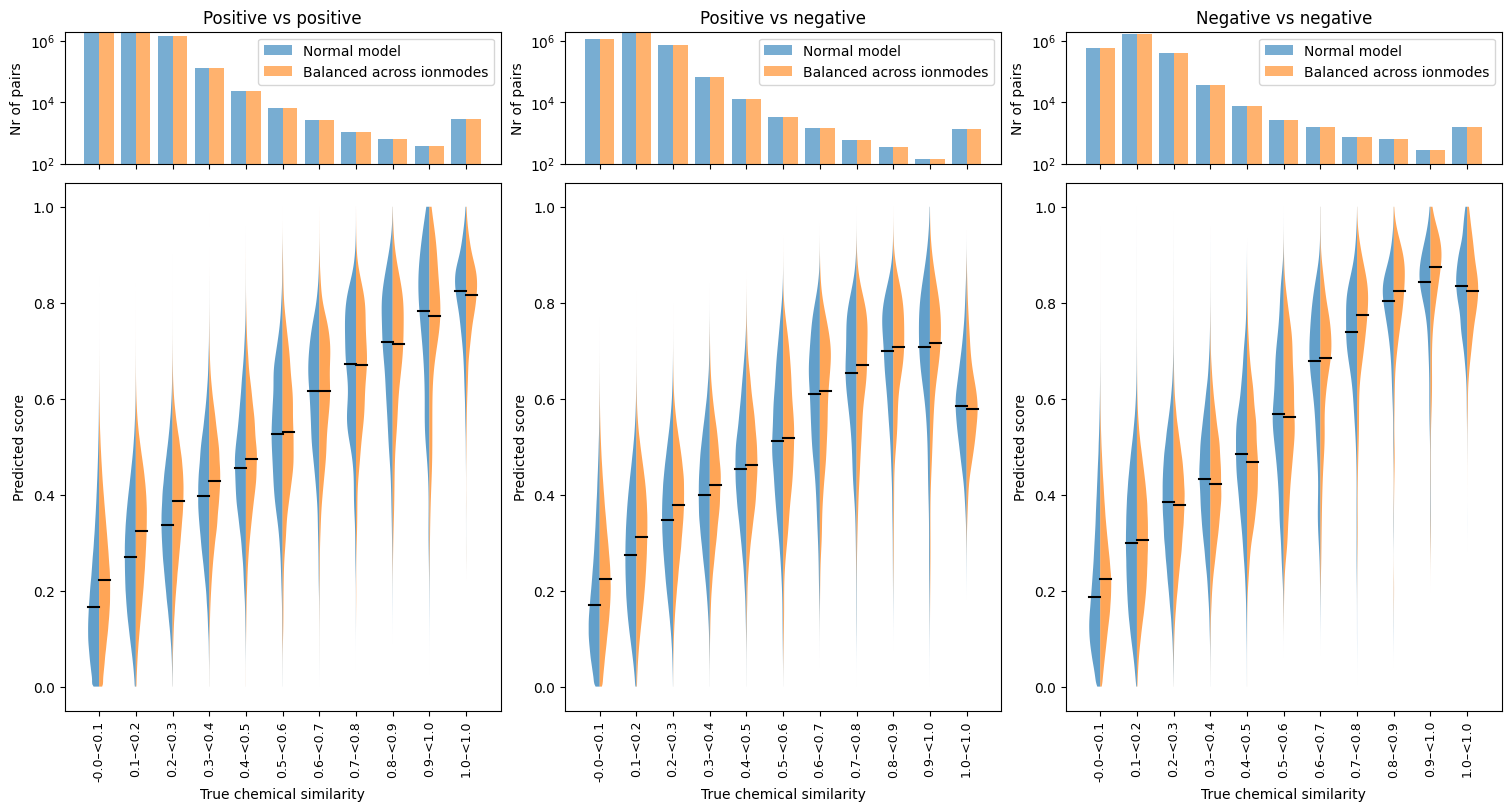

In [62]:
bins = [(-1e-08, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 0.9999),
        (0.9999, 1.0)]
fig = plot_comparison_violinplot_three_panels([scores_normal_model_1.pos_vs_pos_scores, scores_normal_model_1.pos_vs_neg_scores, scores_normal_model_1.neg_vs_neg_scores],
                                              [scores_balanced_model_1.pos_vs_pos_scores, scores_balanced_model_1.pos_vs_neg_scores, scores_balanced_model_1.neg_vs_neg_scores],
                                              bins)

Selecting available inchikey pairs per bin: 13it [00:00, 23.76it/s]
Selecting available inchikey pairs per bin: 13it [00:00, 23.35it/s]
Selecting available inchikey pairs per bin: 13it [00:00, 44.71it/s]
Selecting available inchikey pairs per bin: 13it [00:00, 44.07it/s]
Selecting available inchikey pairs per bin: 13it [00:00, 84.89it/s]
Selecting available inchikey pairs per bin: 13it [00:00, 85.25it/s]


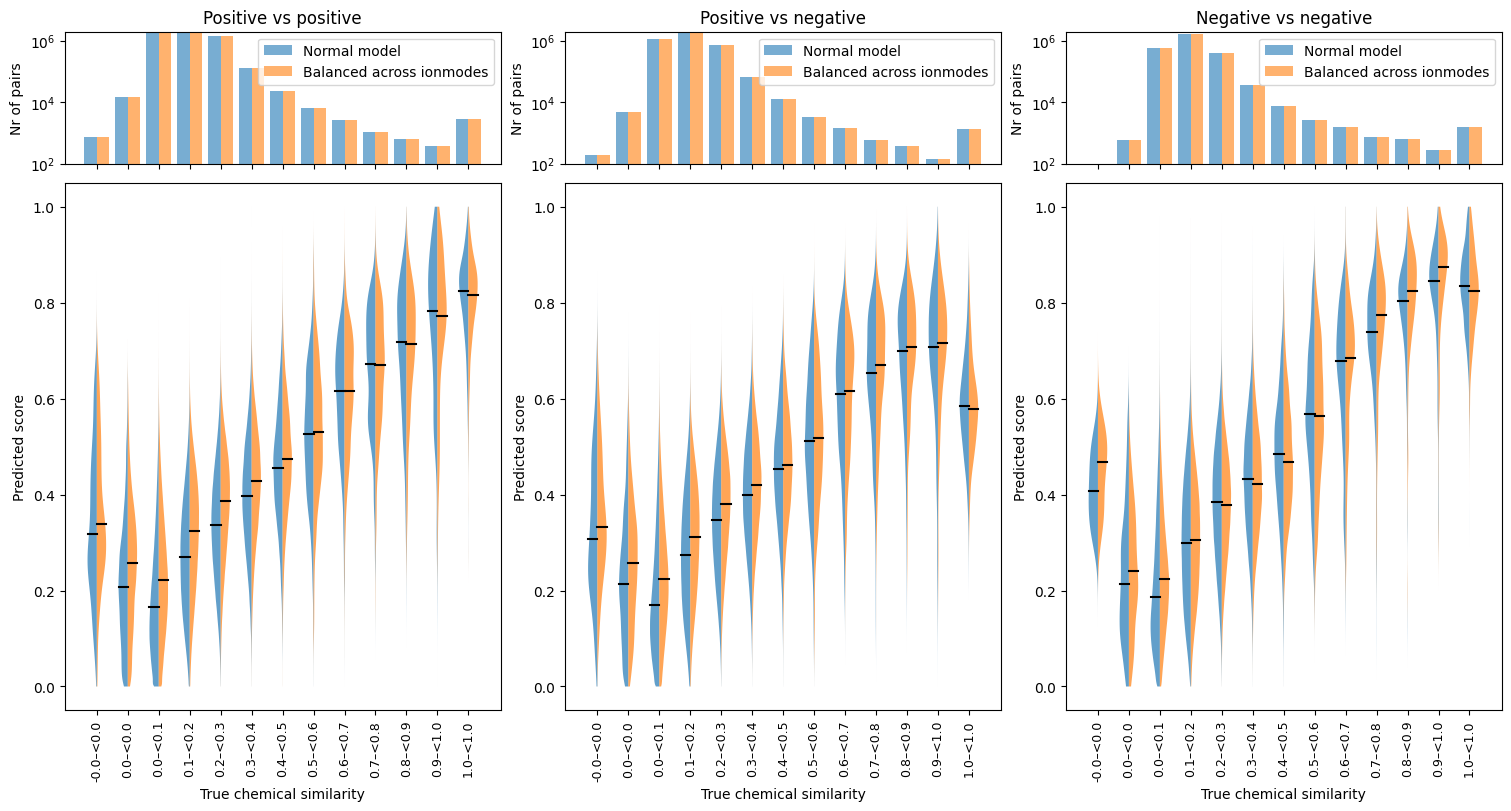

In [73]:
bins = [(-1e-08, 0.001),
        (0.001, 0.01),
        (0.01, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 0.9999),
        (0.9999, 1.0)]
fig = plot_comparison_violinplot_three_panels([scores_normal_model_1.pos_vs_pos_scores, scores_normal_model_1.pos_vs_neg_scores, scores_normal_model_1.neg_vs_neg_scores],
                                              [scores_balanced_model_1.pos_vs_pos_scores, scores_balanced_model_1.pos_vs_neg_scores, scores_balanced_model_1.neg_vs_neg_scores],
                                              bins)

Selecting available inchikey pairs per bin: 12it [00:00, 17.28it/s]
Selecting available inchikey pairs per bin: 12it [00:00, 22.15it/s]
Selecting available inchikey pairs per bin: 12it [00:00, 40.40it/s]
Selecting available inchikey pairs per bin: 12it [00:00, 44.55it/s]
Selecting available inchikey pairs per bin: 12it [00:00, 84.84it/s]
Selecting available inchikey pairs per bin: 12it [00:00, 84.13it/s]


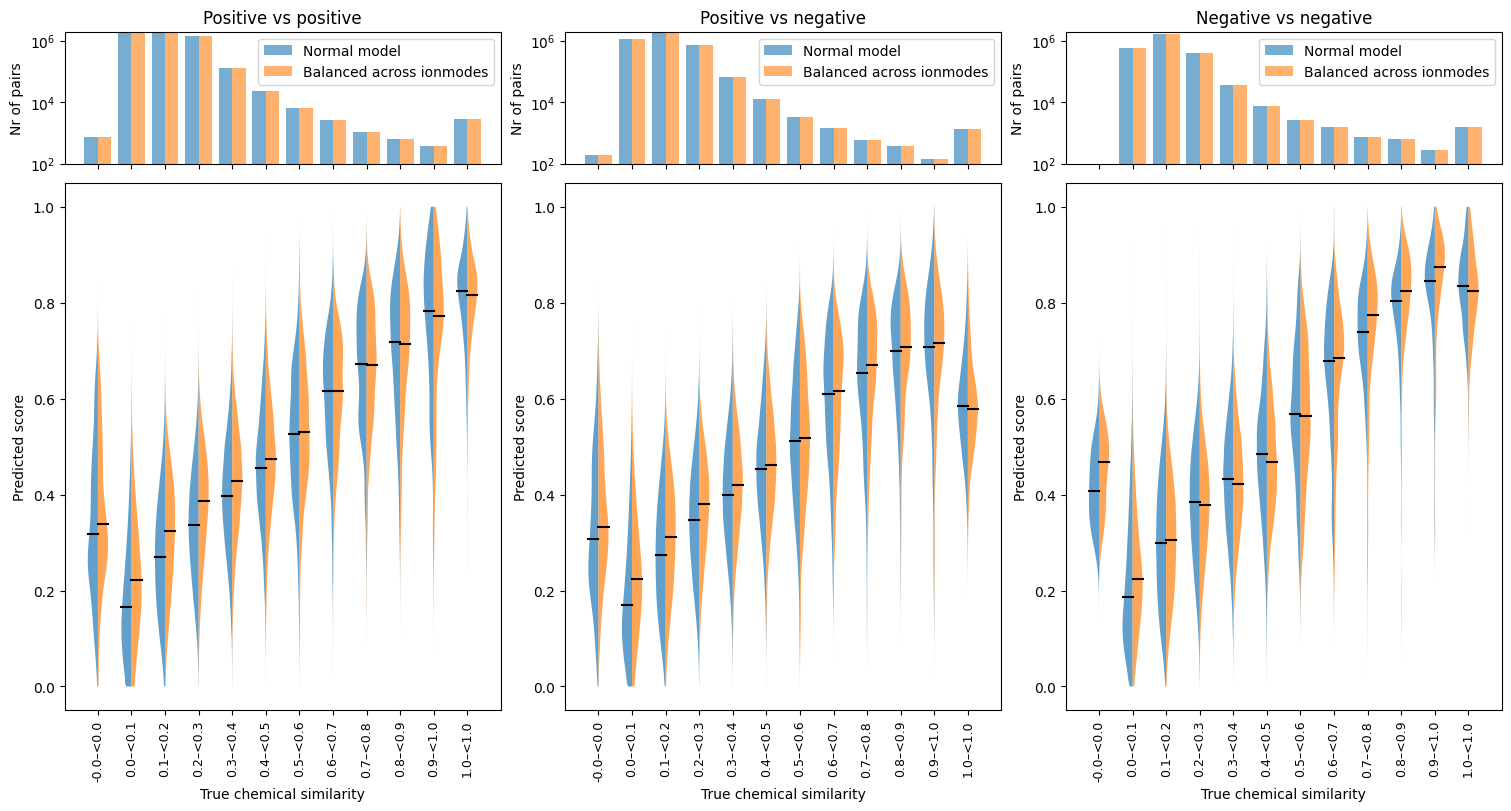

In [72]:
bins = [(-1e-08, 0.001),
        (0.001, 0.01),
        (0.01, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 0.9999),
        (0.9999, 1.0)]
fig = plot_comparison_violinplot_three_panels([scores_normal_model_1.pos_vs_pos_scores, scores_normal_model_1.pos_vs_neg_scores, scores_normal_model_1.neg_vs_neg_scores],
                                              [scores_balanced_model_1.pos_vs_pos_scores, scores_balanced_model_1.pos_vs_neg_scores, scores_balanced_model_1.neg_vs_neg_scores],
                                              bins)

In [12]:
from typing import List

import numpy as np
from matplotlib import pyplot as plt

from ms2deepscore.validation_loss_calculation.PredictionsAndTanimotoScores import PredictionsAndTanimotoScores
from ms2deepscore.utils import create_evenly_spaced_bins

def plot_loss_per_bin_multiple_benchmarks(list_of_predictions_and_tanimoto_scores: List[PredictionsAndTanimotoScores],
                                          nr_of_bins=10,
                                          loss_type="MSE",
                                          title=""):
    """Combines the plot of multiple comparisons into one plot
    """
    ref_score_bins = create_evenly_spaced_bins(nr_of_bins)
    fig = plt.figure(figsize=(5,3))
    labels = []
    for predictions_and_tanimoto_scores in list_of_predictions_and_tanimoto_scores:
        bin_content, rmses = predictions_and_tanimoto_scores.get_average_loss_per_bin_per_inchikey_pair(
            loss_type, ref_score_bins)
        plt.plot(np.arange(len(rmses)), rmses, "o:")
        labels.append(predictions_and_tanimoto_scores.label)
    plt.title(title)
    plt.legend(labels)
    plt.ylabel(loss_type)
    plt.grid(True)
    plt.xlabel("tanimoto score bin")
    plt.xticks(np.arange(len(ref_score_bins)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in ref_score_bins], fontsize=9, rotation='vertical')
    plt.grid(True)
    plt.tight_layout()
    return fig

Selecting available inchikey pairs per bin: 10it [00:00, 76.31it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 76.79it/s]


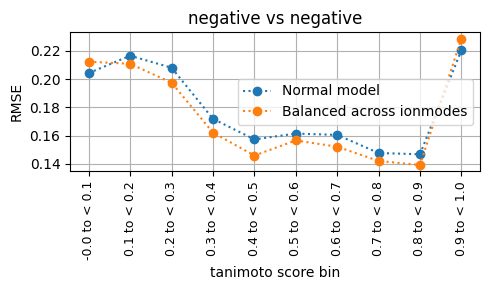

In [16]:
figure = plot_loss_per_bin_multiple_benchmarks([scores_normal_model_1.neg_vs_neg_scores, scores_balanced_model_1.neg_vs_neg_scores], 10, "RMSE", "negative vs negative")


Selecting available inchikey pairs per bin: 10it [00:00, 20.27it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 20.32it/s]


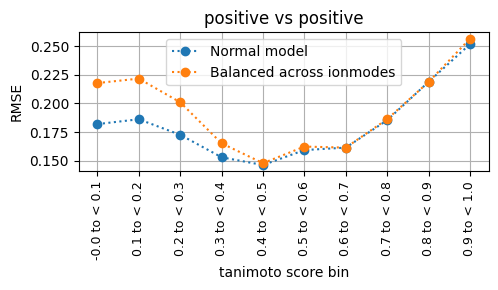

In [17]:
figure = plot_loss_per_bin_multiple_benchmarks([scores_normal_model_1.pos_vs_pos_scores, scores_balanced_model_1.pos_vs_pos_scores], 10, "RMSE", "positive vs positive")


Selecting available inchikey pairs per bin: 10it [00:00, 39.85it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 39.69it/s]


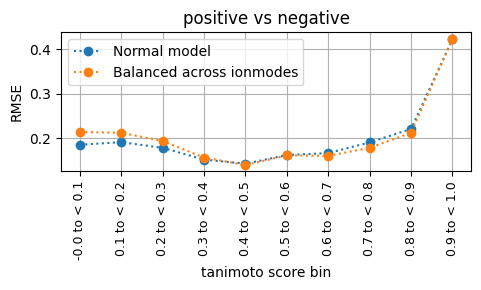

In [18]:
figure = plot_loss_per_bin_multiple_benchmarks([scores_normal_model_1.pos_vs_neg_scores, scores_balanced_model_1.pos_vs_neg_scores], 10, "RMSE", "positive vs negative")


# Redo for old test set
There will of course be data leakage, this is just a sanity check, to make sure it is the test set that became more difficult. It seems to be the case that it is something test set specific, but we don't fully understand what is going on.

In [29]:
neg_test = list(tqdm(load_from_mgf("/lustre/BIF/nobackup/jonge094/ms2deepscore/data/pytorch/new_corinna_included/training_and_validation_split/negative_testing_spectra.mgf")))
pos_test = list(tqdm(load_from_mgf("/lustre/BIF/nobackup/jonge094/ms2deepscore/data/pytorch/new_corinna_included/training_and_validation_split/positive_testing_spectra.mgf")))

7142it [00:02, 2540.73it/s]
24911it [00:09, 2566.56it/s]


In [30]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_normal_model = CalculateScoresBetweenAllIonmodes(normal_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)
scores_balanced_model = CalculateScoresBetweenAllIonmodes(balanced_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)

/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


24911it [00:25, 973.65it/s]
7142it [00:07, 973.28it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 309.66it/s]


Calculating tanimoto scores
Calculating embeddings


24911it [00:25, 968.49it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:05<00:00, 315.82it/s]


Calculating tanimoto scores
Calculating embeddings


7142it [00:07, 971.02it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 305.47it/s]


Calculating tanimoto scores


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


24911it [00:25, 972.55it/s]
7142it [00:07, 973.24it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 307.42it/s]


Calculating tanimoto scores
Calculating embeddings


24911it [00:25, 966.07it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:05<00:00, 313.86it/s]


Calculating tanimoto scores
Calculating embeddings


7142it [00:07, 962.44it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 307.41it/s]


Calculating tanimoto scores


In [31]:
scores_normal_model.neg_vs_neg_scores.label = "Normal model"
scores_normal_model.pos_vs_pos_scores.label = "Normal model"
scores_normal_model.pos_vs_neg_scores.label = "Normal model"

scores_balanced_model.neg_vs_neg_scores.label="Balanced across ionmodes"
scores_balanced_model.pos_vs_pos_scores.label="Balanced across ionmodes"
scores_balanced_model.pos_vs_neg_scores.label="Balanced across ionmodes"

Selecting available inchikey pairs per bin: 10it [00:00, 60.05it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 59.94it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 94.22it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 120.04it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 257.35it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 261.44it/s]


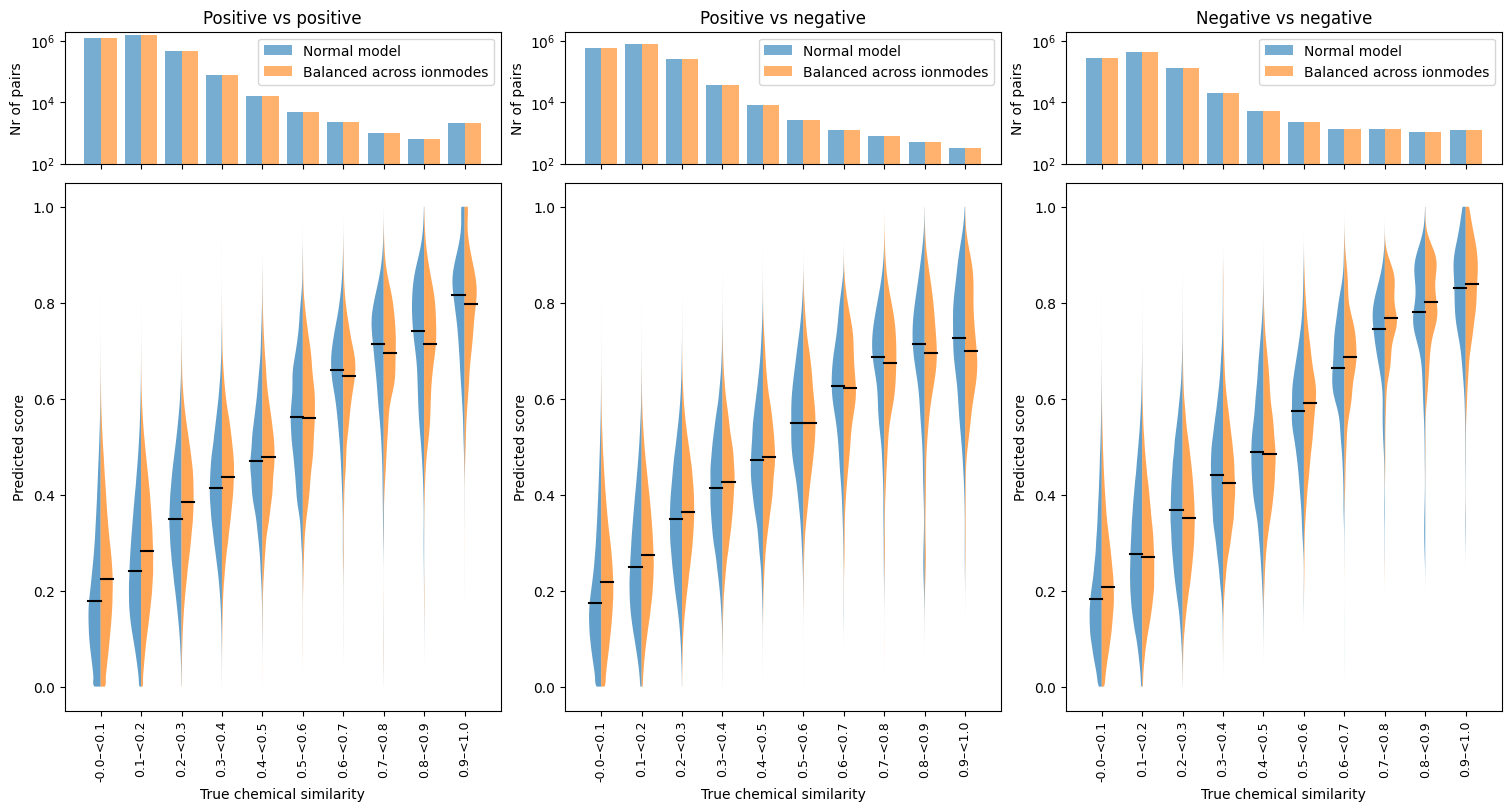

In [32]:
fig = plot_comparison_violinplot_three_panels([scores_normal_model.pos_vs_pos_scores, scores_normal_model.pos_vs_neg_scores, scores_normal_model.neg_vs_neg_scores],
                                              [scores_balanced_model.pos_vs_pos_scores, scores_balanced_model.pos_vs_neg_scores, scores_balanced_model.neg_vs_neg_scores],
                                              10)

Selecting available inchikey pairs per bin: 11it [00:00, 63.32it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 63.71it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 123.30it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 125.02it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 272.29it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 270.06it/s]


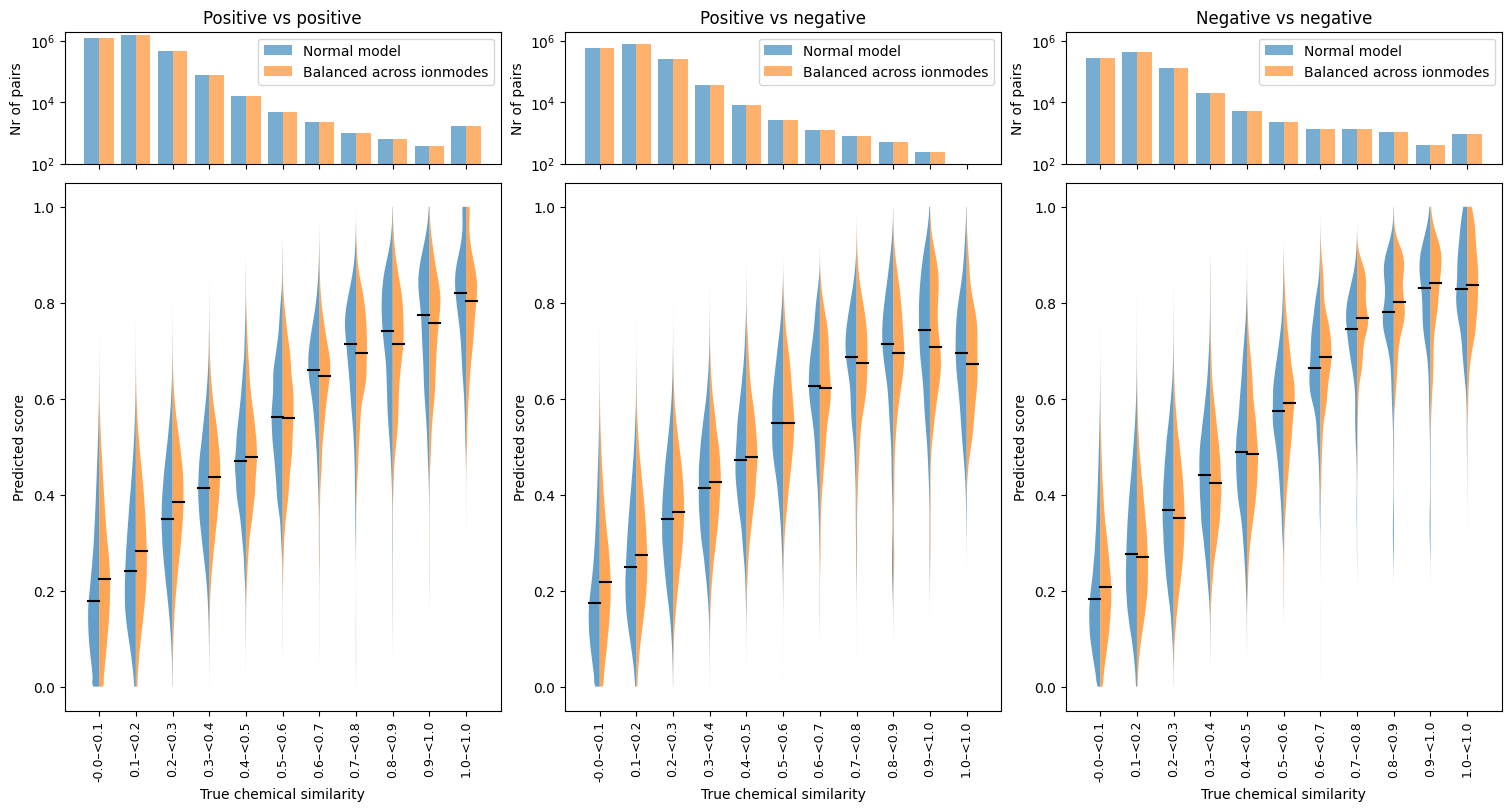

In [43]:
bins = [(-1e-08, 0.1),
 (0.1, 0.2),
 (0.2, 0.3),
 (0.3, 0.4),
 (0.4, 0.5),
 (0.5, 0.6),
 (0.6, 0.7),
 (0.7, 0.8),
 (0.8, 0.9),
 (0.9, 0.99),
        (0.99, 1.0)]
fig = plot_comparison_violinplot_three_panels([scores_normal_model.pos_vs_pos_scores, scores_normal_model.pos_vs_neg_scores, scores_normal_model.neg_vs_neg_scores],
                                              [scores_balanced_model.pos_vs_pos_scores, scores_balanced_model.pos_vs_neg_scores, scores_balanced_model.neg_vs_neg_scores],
                                              bins)

Selecting available inchikey pairs per bin: 10it [00:00, 249.38it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 252.85it/s]


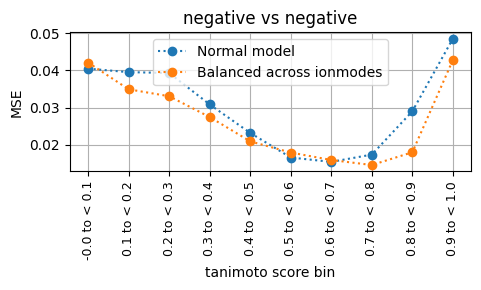

In [33]:
figure = plot_loss_per_bin_multiple_benchmarks([scores_normal_model.neg_vs_neg_scores, scores_balanced_model.neg_vs_neg_scores], 10, "MSE", "negative vs negative")


Selecting available inchikey pairs per bin: 10it [00:00, 59.77it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 59.36it/s]


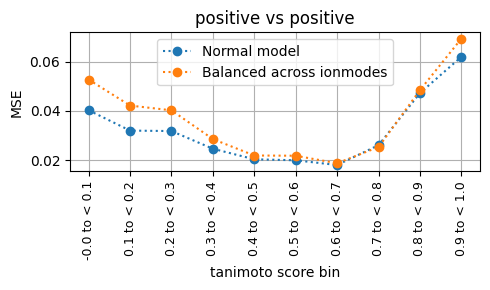

In [34]:
figure = plot_loss_per_bin_multiple_benchmarks([scores_normal_model.pos_vs_pos_scores, scores_balanced_model.pos_vs_pos_scores], 10, "MSE", "positive vs positive")


Selecting available inchikey pairs per bin: 10it [00:00, 121.71it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 121.31it/s]


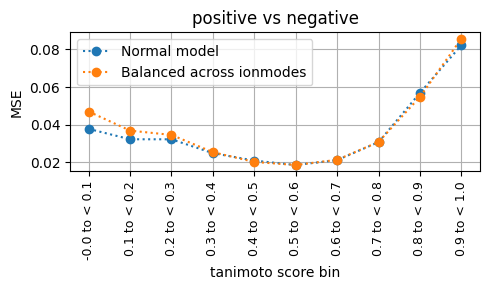

In [35]:
figure = plot_loss_per_bin_multiple_benchmarks([scores_normal_model.pos_vs_neg_scores, scores_balanced_model.pos_vs_neg_scores], 10, "MSE", "positive vs negative")


# Run on only GNPS test spectra

In [ ]:
gnps_spectra = []
for spectrum in test_spectra:
    if spectrum.get("spectype") is None:
        gnps_spectra.append(spectrum)
print(len(gnps_spectra))

In [57]:
pos_test, neg_test = split_by_ionmode(gnps_spectra)
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_normal_model_gnps = CalculateScoresBetweenAllIonmodes(normal_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)
scores_balanced_model_gnps = CalculateScoresBetweenAllIonmodes(balanced_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)

Splitting pos and neg mode spectra: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33709/33709 [00:00<00:00, 643431.89it/s]
/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during 

The spectra, are split in 24174 positive spectra and 9535 negative mode spectra. 0 were removed
Calculating embeddings


24174it [00:24, 969.83it/s]
9535it [00:09, 973.79it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:03<00:00, 315.59it/s]


Calculating tanimoto scores
Calculating embeddings


24174it [00:24, 971.66it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2218/2218 [00:06<00:00, 319.79it/s]


Calculating tanimoto scores
Calculating embeddings


9535it [00:09, 974.63it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:03<00:00, 317.11it/s]


Calculating tanimoto scores


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


24174it [00:24, 971.13it/s]
9535it [00:09, 974.63it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:04<00:00, 301.10it/s]


Calculating tanimoto scores
Calculating embeddings


24174it [00:24, 969.49it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2218/2218 [00:07<00:00, 315.87it/s]


Calculating tanimoto scores
Calculating embeddings


9535it [00:09, 965.39it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1240/1240 [00:03<00:00, 314.89it/s]


Calculating tanimoto scores


Selecting available inchikey pairs per bin: 11it [00:00, 42.21it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 42.64it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 76.06it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 78.91it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 152.71it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 149.56it/s]


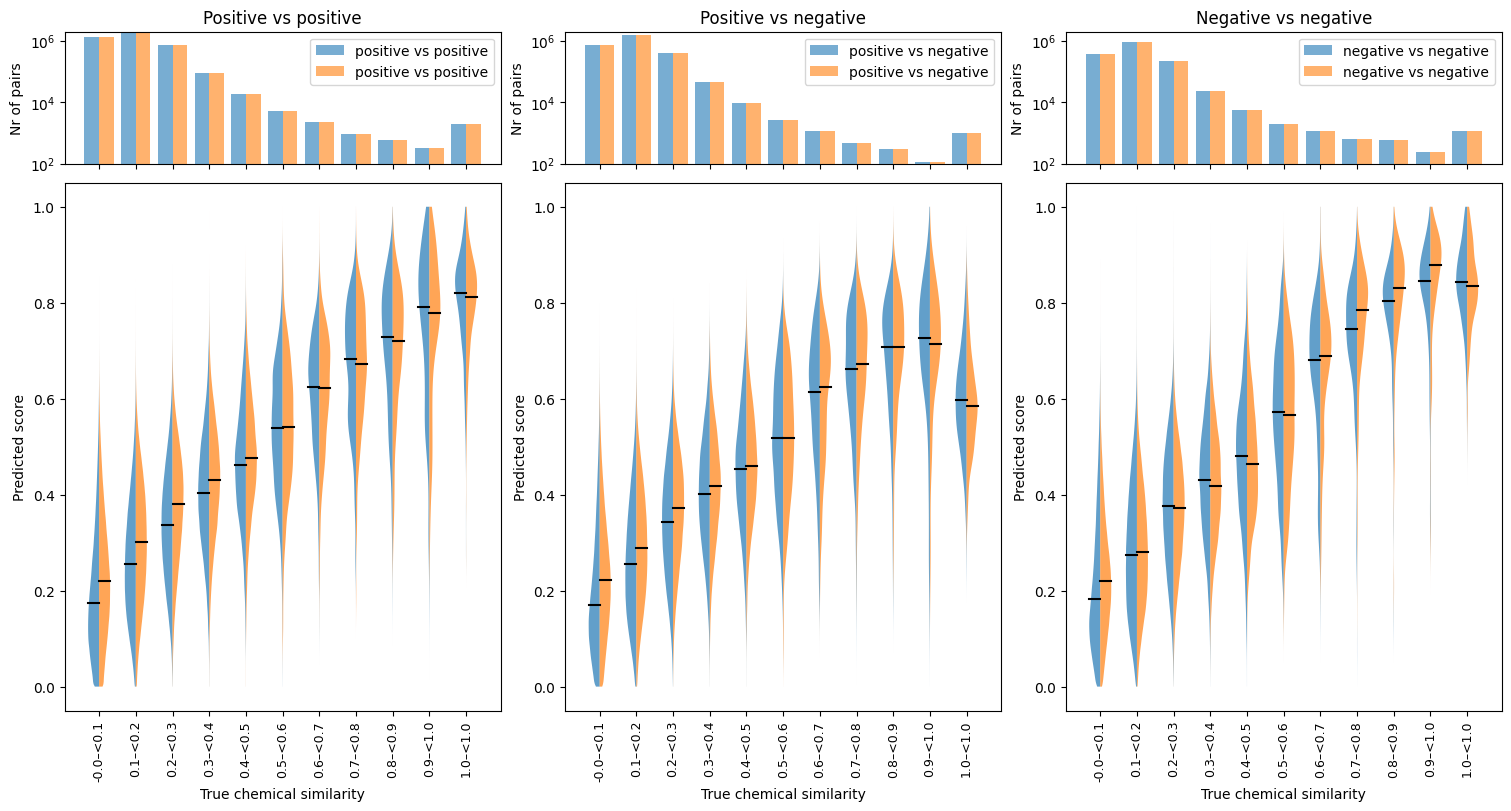

In [59]:
fig = plot_comparison_violinplot_three_panels([scores_normal_model_gnps.pos_vs_pos_scores, scores_normal_model_gnps.pos_vs_neg_scores, scores_normal_model_gnps.neg_vs_neg_scores],
                                              [scores_balanced_model_gnps.pos_vs_pos_scores, scores_balanced_model_gnps.pos_vs_neg_scores, scores_balanced_model_gnps.neg_vs_neg_scores],
                                              bins)

# Run only on spectra which ionize in both modes

In [67]:
pos_inchikeys = []
neg_inchikeys = []
for spectrum in test_spectra:
    if spectrum.get("ionmode") == "positive":
        pos_inchikeys.append(spectrum.get("inchikey")[:14])
    else:
        neg_inchikeys.append(spectrum.get("inchikey")[:14])
    
print(len(set(pos_inchikeys)))
print(len(set(neg_inchikeys)))
print(len(set(neg_inchikeys)&set(pos_inchikeys)))
inchikeys_ionizing_in_both_modes = set(neg_inchikeys)&set(pos_inchikeys)

both_modes_ionizing = []
for spectrum in test_spectra:
    if spectrum.get("inchikey")[:14] in inchikeys_ionizing_in_both_modes:
        both_modes_ionizing.append(spectrum)

3092
1659
1369


In [69]:
pos_test, neg_test = split_by_ionmode(both_modes_ionizing)
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_normal_model_both_modes_ionizing = CalculateScoresBetweenAllIonmodes(normal_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)
scores_balanced_model_both_modes_ionizing = CalculateScoresBetweenAllIonmodes(balanced_model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)

Splitting pos and neg mode spectra: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31796/31796 [00:00<00:00, 444444.00it/s]
/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during 

The spectra, are split in 18327 positive spectra and 13469 negative mode spectra. 0 were removed
Calculating embeddings


18327it [00:19, 964.03it/s]
13469it [00:13, 967.01it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [00:04<00:00, 317.57it/s]


Calculating tanimoto scores
Calculating embeddings


18327it [00:18, 965.99it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [00:04<00:00, 311.74it/s]


Calculating tanimoto scores
Calculating embeddings


13469it [00:13, 963.65it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [00:04<00:00, 311.56it/s]


Calculating tanimoto scores


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


18327it [00:18, 967.43it/s]
13469it [00:13, 969.48it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [00:04<00:00, 302.92it/s]


Calculating tanimoto scores
Calculating embeddings


18327it [01:39, 183.82it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [00:04<00:00, 316.72it/s]


Calculating tanimoto scores
Calculating embeddings


13469it [00:13, 971.04it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [00:04<00:00, 309.37it/s]


Calculating tanimoto scores


In [70]:
scores_normal_model_both_modes_ionizing.neg_vs_neg_scores.label = "Normal model"
scores_normal_model_both_modes_ionizing.pos_vs_pos_scores.label = "Normal model"
scores_normal_model_both_modes_ionizing.pos_vs_neg_scores.label = "Normal model"

scores_balanced_model_both_modes_ionizing.neg_vs_neg_scores.label="Balanced across ionmodes"
scores_balanced_model_both_modes_ionizing.pos_vs_pos_scores.label="Balanced across ionmodes"
scores_balanced_model_both_modes_ionizing.pos_vs_neg_scores.label="Balanced across ionmodes"

Selecting available inchikey pairs per bin: 11it [00:00, 120.74it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 120.28it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 119.77it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 120.53it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 118.35it/s]
Selecting available inchikey pairs per bin: 11it [00:00, 120.38it/s]


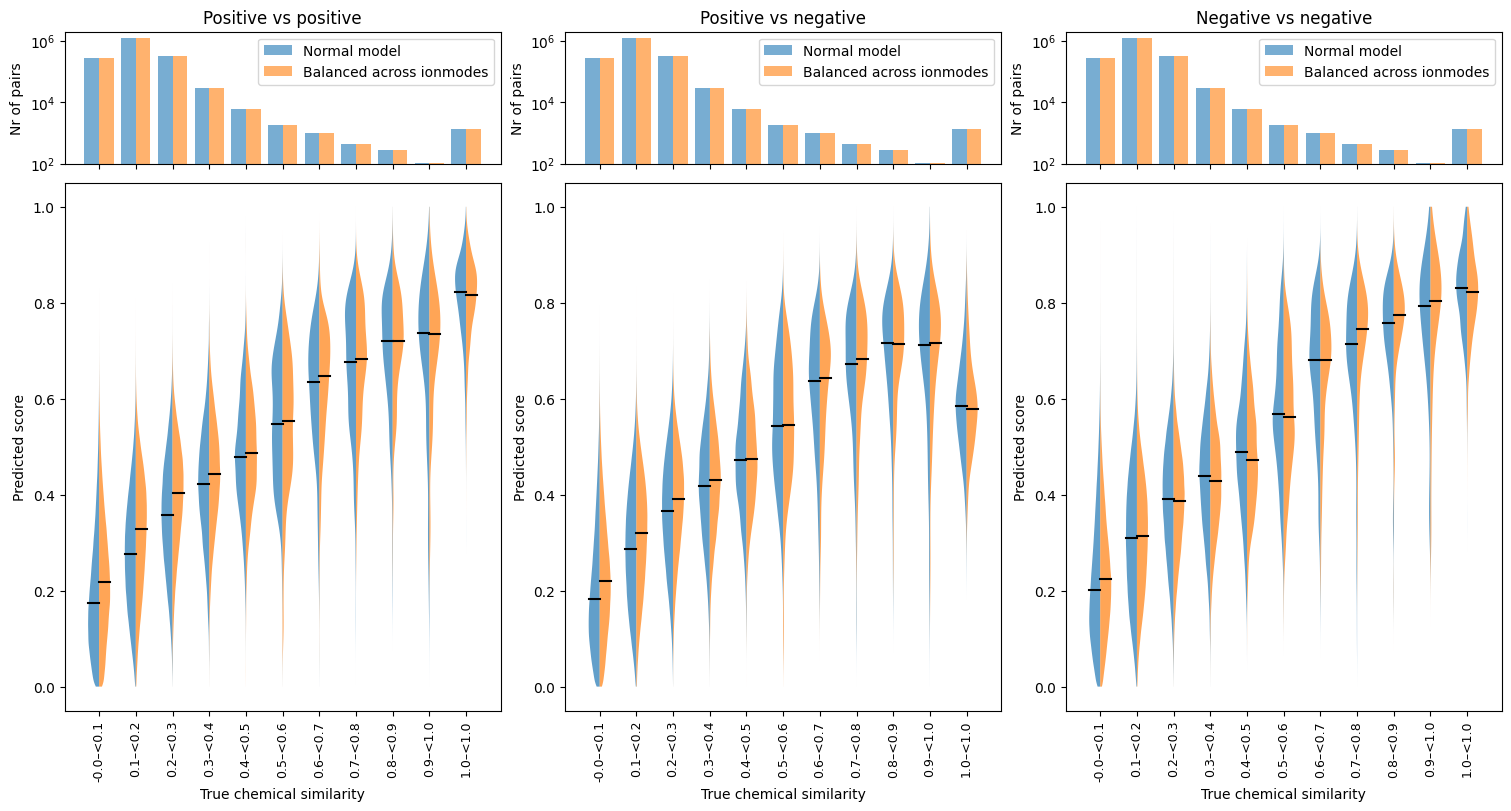

In [71]:
fig = plot_comparison_violinplot_three_panels([scores_normal_model_both_modes_ionizing.pos_vs_pos_scores, scores_normal_model_both_modes_ionizing.pos_vs_neg_scores, scores_normal_model_both_modes_ionizing.neg_vs_neg_scores],
                                              [scores_balanced_model_both_modes_ionizing.pos_vs_pos_scores, scores_balanced_model_both_modes_ionizing.pos_vs_neg_scores, scores_balanced_model_both_modes_ionizing.neg_vs_neg_scores],
                                              bins)